# Bibliotecas

In [75]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [2]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})    

# Carregando os dados iniciais

In [3]:
df = pd.read_csv("solicitacoescredito.csv")
df.head()

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.0,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.0,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,...,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.0,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.0,89000.0,2020-02-04T15:06:28


In [4]:
df_temporal = df[['dataAprovadoNivelAnalista', 'dataAprovadoEmComite', 'valorAprovado']]
df_temporal['dataAprovadoEmComite'].fillna(df_temporal['dataAprovadoNivelAnalista'], inplace=True)
df_temporal.drop('dataAprovadoNivelAnalista', axis=1, inplace=True)
df_temporal.rename({'dataAprovadoEmComite': 'data'}, axis=1, inplace=True)
df_temporal.dropna(inplace=True)
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7569 entries, 0 to 8961
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   data           7569 non-null   object 
 1   valorAprovado  7569 non-null   float64
dtypes: float64(1), object(1)
memory usage: 177.4+ KB


In [5]:
df_temporal.data[0][:-9]
df_temporal.data = [x[:-9] for x in df_temporal.data]
df_temporal.valorAprovado = df_temporal.valorAprovado.astype('int64')
df_temporal

,data,valorAprovado
0,2020-02-03,50000
2,2020-02-04,20000
3,2020-02-04,15000
4,2020-02-04,50000
5,2020-02-04,20000
...,...,...
8956,2021-02-25,45000
8957,2021-02-25,15000
8958,2021-02-25,1500000
8960,2021-02-25,20000


In [6]:
df_temporal_agrupado = df_temporal.groupby('data', as_index=False).sum()
df_temporal_agrupado.sort_values('data', inplace=True)
df_temporal_agrupado

,data,valorAprovado
0,2020-02-03,50000
1,2020-02-04,1243000
2,2020-02-05,2952000
3,2020-02-06,5545000
4,2020-02-07,4685000
...,...,...
259,2021-02-19,7911900
260,2021-02-22,4272000
261,2021-02-23,13826500
262,2021-02-24,7255000


In [7]:
df_base_dias = pd.date_range(start='2020-02-03', end='2021-02-25')
df_base_dias = df_base_dias.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
df_base_dias = pd.DataFrame(df_base_dias, columns=['data'])
df_base_dias

,data
0,2020-02-03
1,2020-02-04
2,2020-02-05
3,2020-02-06
4,2020-02-07
...,...
384,2021-02-21
385,2021-02-22
386,2021-02-23
387,2021-02-24


In [8]:
df_temporal = pd.merge(df_base_dias, df_temporal_agrupado, how='left')
df_temporal.data = df_temporal.index + 1
df_temporal.rename({'data': 'dia', 'valorAprovado': 'valor'}, axis=1, inplace=True)
df_temporal.head(20)

,dia,valor
0,1,50000.0
1,2,1243000.0
2,3,2952000.0
3,4,5545000.0
4,5,4685000.0
5,6,NaN
6,7,NaN
7,8,NaN
8,9,746500.0
9,10,3918000.0


In [9]:
df_temporal.isnull().sum()

dia        0
valor    125
dtype: int64

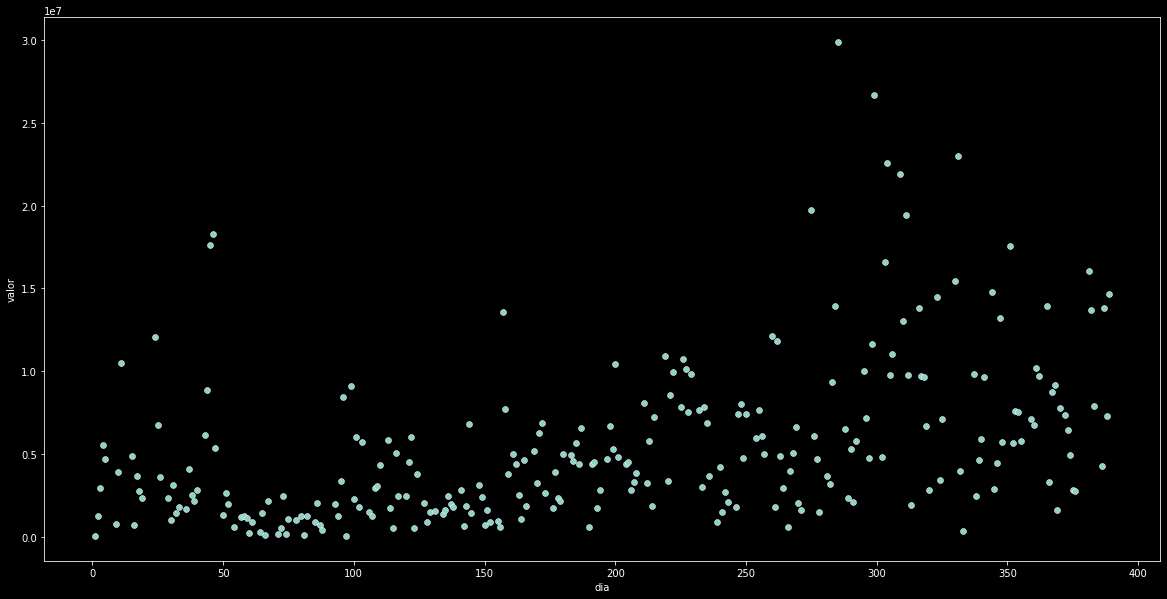

In [10]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=df_temporal.dia, y=df_temporal.valor)
plt.show()

In [11]:
imputer = KNNImputer(n_neighbors=2)
knn = imputer.fit_transform(df_temporal)
knn = knn.astype('int64')
knn

array([[       1,    50000],
       [       2,  1243000],
       [       3,  2952000],
       [       4,  5545000],
       [       5,  4685000],
       [       6,  5115000],
       [       7,  2715750],
       [       8,  2332250],
       [       9,   746500],
       [      10,  3918000],
       [      11, 10493000],
       [      12,  7205500],
       [      13,  7690500],
       [      14,  2805000],
       [      15,  4888000],
       [      16,   722000],
       [      17,  3641400],
       [      18,  2737800],
       [      19,  2330000],
       [      20,  2533900],
       [      21,  2533900],
       [      22,  7193750],
       [      23,  9411950],
       [      24, 12057500],
       [      25,  6766400],
       [      26,  3601200],
       [      27,  5183800],
       [      28,  2963600],
       [      29,  2326000],
       [      30,  1004000],
       [      31,  3133000],
       [      32,  1415000],
       [      33,  1756950],
       [      34,  1585975],
       [      

In [110]:
df_dias = pd.DataFrame(knn[:,1], columns=['valor'])
df_dias.head(20)

,valor
0,50000
1,1243000
2,2952000
3,5545000
4,4685000
5,5115000
6,2715750
7,2332250
8,746500
9,3918000


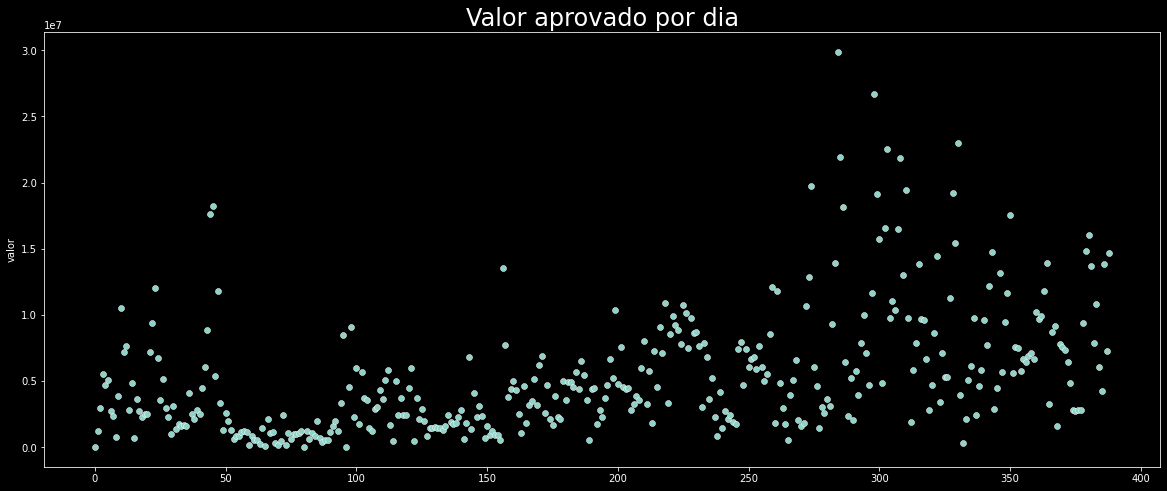

In [13]:
fig = plt.figure(figsize=(20,8))
sns.scatterplot(x=df_dias.index, y=df_dias.valor)
plt.title('Valor aprovado por dia', size=24)
plt.show()

<AxesSubplot:ylabel='Count'>

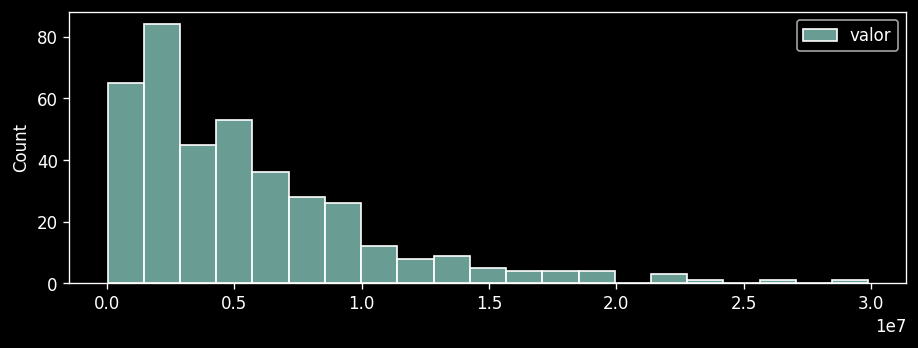

In [109]:
sns.histplot(df_dias)

In [111]:
df_dias.describe()

,valor
count,3.890000e+02
mean,5.433915e+06
std,4.767037e+06
min,2.500000e+04
25%,1.990000e+06
50%,4.325000e+06
75%,7.423000e+06
max,2.989260e+07


# Modelo ARIMA

# Previsão por Dia

In [14]:
df_arima = df_dias.copy()

result = adfuller(df_arima)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.398396
p-value: 0.142190


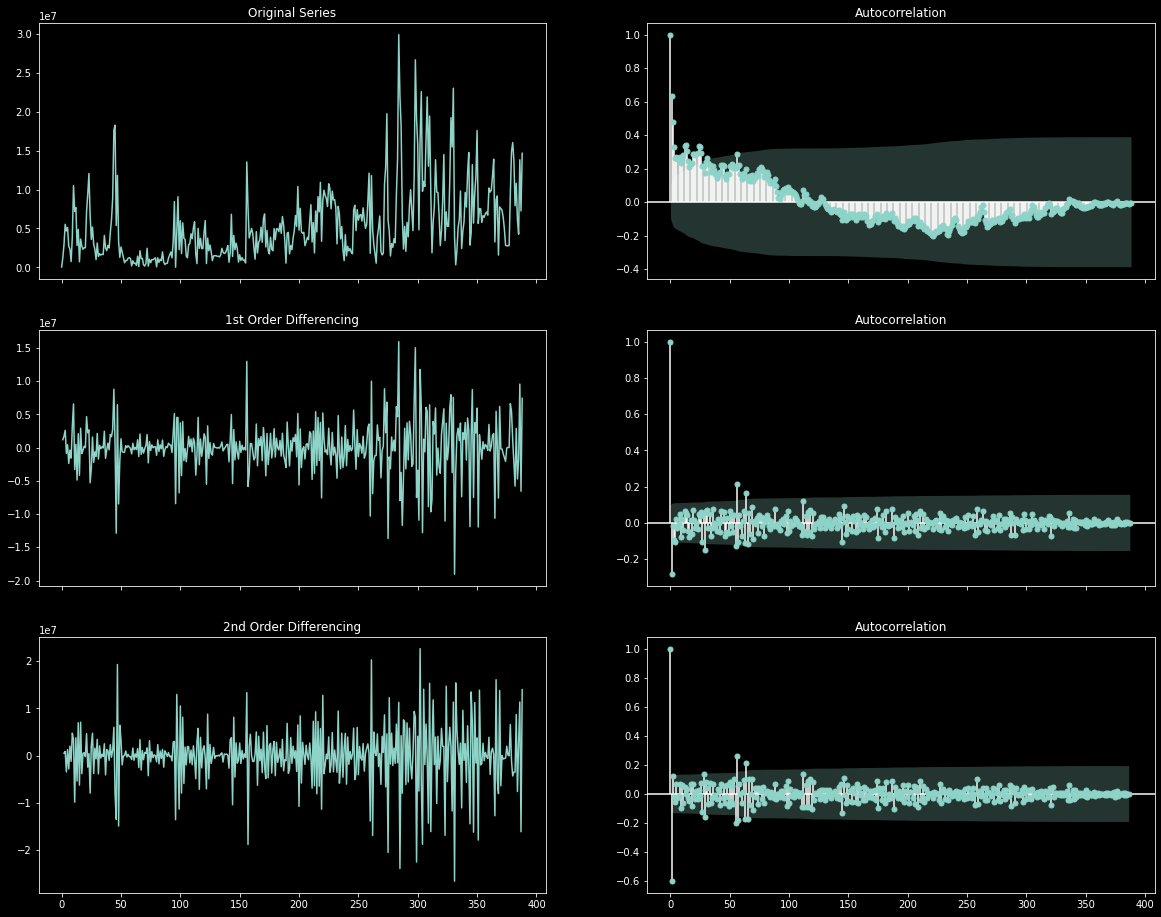

In [15]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(20,16))
axes[0, 0].plot(df_arima.valor)
axes[0, 0].set_title('Original Series')
plot_acf(df_arima.valor, ax=axes[0, 1], lags=388)

# 1st Differencing
axes[1, 0].plot(df_arima.valor.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_arima.valor.diff().dropna(), ax=axes[1, 1], lags=387)

# 2nd Differencing
axes[2, 0].plot(df_arima.valor.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_arima.valor.diff().diff().dropna(), ax=axes[2, 1], lags=386)

plt.show()


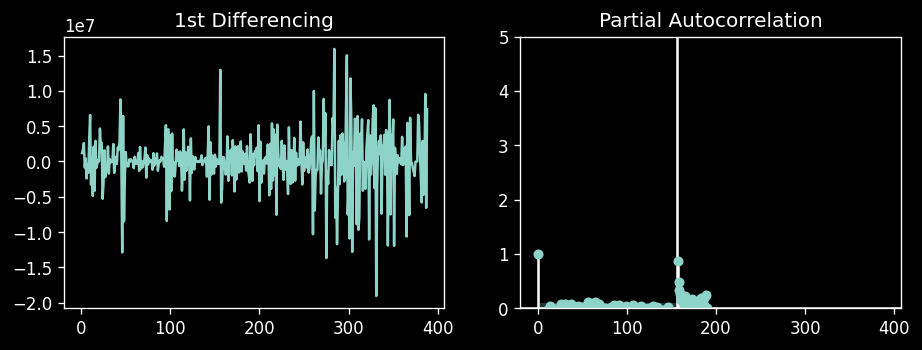

In [16]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_arima.valor.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_arima.valor.diff().dropna(), ax=axes[1], lags=190)

plt.show()

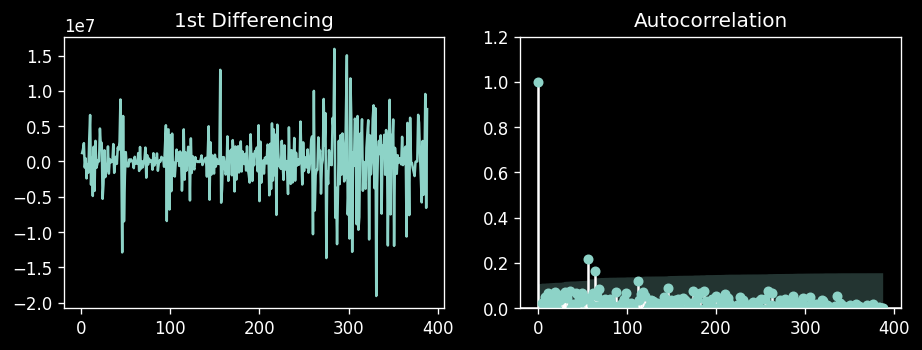

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_arima.valor.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_arima.valor.diff().dropna(), ax=axes[1], lags=387)

plt.show()

In [18]:
model = ARIMA(df_arima.valor, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.valor   No. Observations:                  388
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6405.782
Method:                       css-mle   S.D. of innovations        3572854.819
Date:                Tue, 07 Sep 2021   AIC                          12819.564
Time:                        18:19:39   BIC                          12835.408
Sample:                             1   HQIC                         12825.846
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.766e+04   5.47e+04      0.689      0.491   -6.95e+04    1.45e+05
ar.L1.D.valor     0.4911      0.062      7.947      0.000       0.370       0.612
ma.L1.D.valor    -0.9579      0.057    -

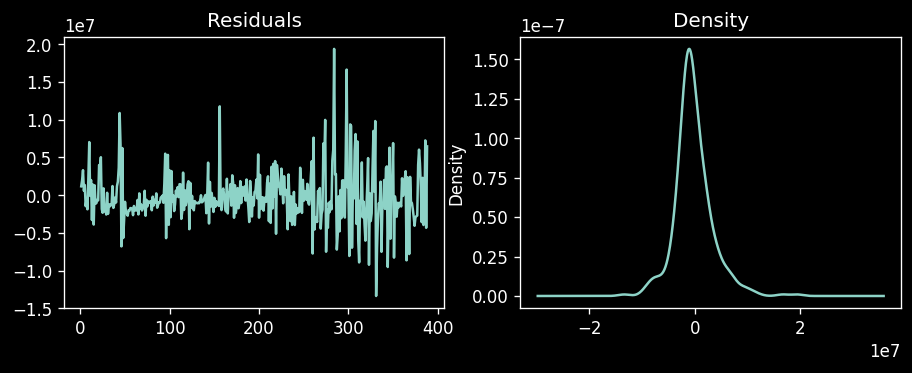

In [19]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], legend=False)
residuals.plot(kind='kde', title='Density', ax=ax[1], legend=False)
plt.show()

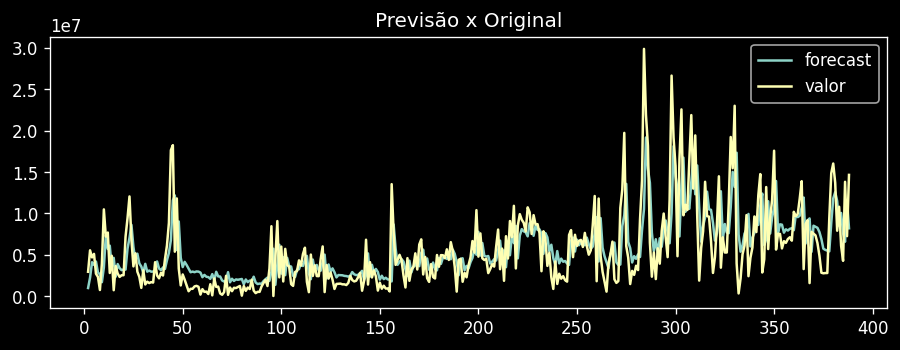

In [20]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.title('Previsão x Original')
plt.show()

In [21]:
# Create Training and Test
train_arima = df_arima.valor[:374]
test_arima = df_arima.valor[374:]

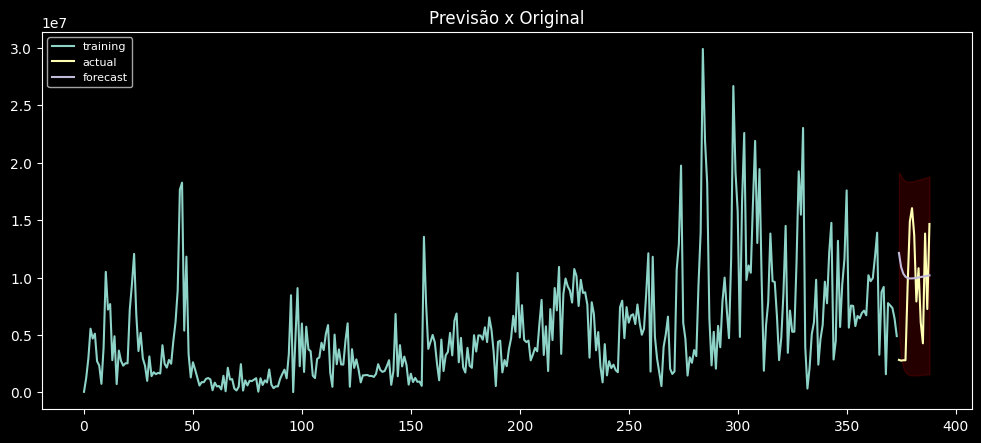

In [22]:
model = ARIMA(df_arima.valor, order=(1,1,1))
model_fit = model.fit(disp=1)

# Forecast
fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_arima.index)
lower_series = pd.Series(conf[:, 0], index=test_arima.index)
upper_series = pd.Series(conf[:, 1], index=test_arima.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_arima, label='training')
plt.plot(test_arima, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='r', alpha=.15)
plt.title('Previsão x Original')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
mean_absolute_percentage_error(fc_series, test_arima)

0.4574706397104645

# Previsão por Dias

In [24]:
X = np.array(df_dias.valor)
X = X.astype('float32').reshape(-1,1)

In [25]:
X.shape

(389, 1)

In [26]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [27]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

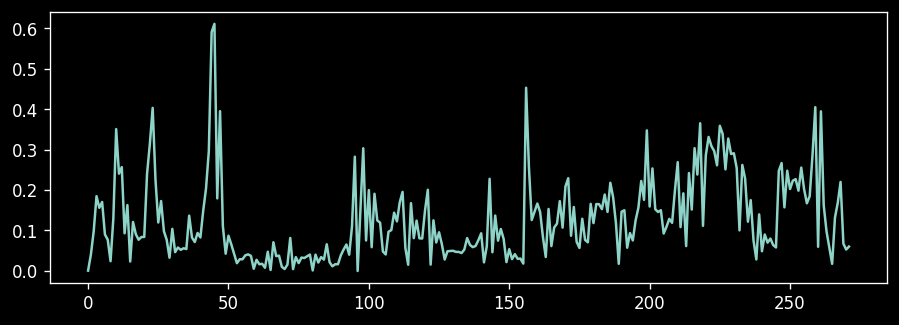

In [28]:
plt.plot(train)

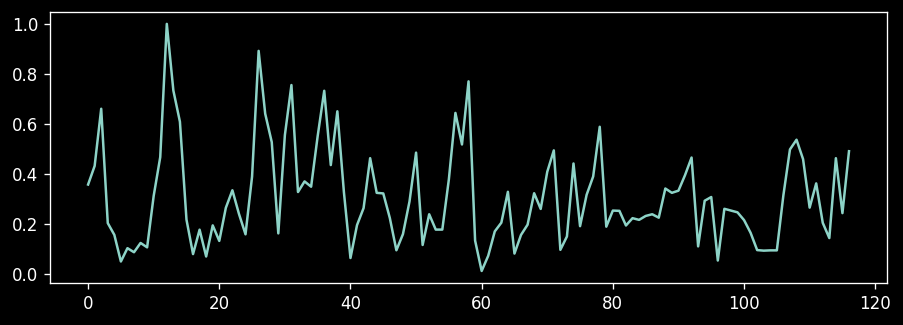

In [29]:
plt.plot(test)

In [ ]:
best = 0
best_mse = np.Infinity
for n in range(1, 101, 5):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

In [100]:
train

array([[0.00083703],
       [0.04077997],
       [0.09799917],
       [0.18481566],
       [0.15602191],
       [0.17041878],
       [0.09008926],
       [0.07724926],
       [0.02415661],
       [0.13034192],
       [0.3504801 ],
       [0.24041101],
       [0.25664935],
       [0.09307745],
       [0.16281858],
       [0.02333632],
       [0.12108104],
       [0.09082752],
       [0.07717393],
       [0.08400072],
       [0.08400072],
       [0.24001761],
       [0.3142854 ],
       [0.4028613 ],
       [0.22570947],
       [0.1197351 ],
       [0.17272228],
       [0.09838755],
       [0.07704   ],
       [0.03277799],
       [0.10405925],
       [0.04653873],
       [0.05798759],
       [0.05226316],
       [0.05611348],
       [0.05423938],
       [0.13672006],
       [0.08265813],
       [0.07145167],
       [0.09391448],
       [0.08268307],
       [0.14880674],
       [0.203699  ],
       [0.2961403 ],
       [0.5899805 ],
       [0.6103343 ],
       [0.17924105],
       [0.394

In [101]:
# quantidade de atrasos
look_back = 81

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [106]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [107]:
X_train.shape

(266, 5, 1)

In [108]:
y_train.shape

(266,)

# Modelo LSTM

In [71]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [73]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Epoch 1/100
183/190 [===========================>..] - ETA: 0s - loss: 0.0074
Epoch 00001: val_loss improved from inf to 0.02052, saving model to .\modelo_lstm_ex4.hdf5
190/190 [==============================] - 1s 6ms/step - loss: 0.0073 - val_loss: 0.0205
Epoch 2/100
189/190 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00002: val_loss did not improve from 0.02052
190/190 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0216
Epoch 3/100
178/190 [===========================>..] - ETA: 0s - loss: 0.0065
Epoch 00003: val_loss improved from 0.02052 to 0.01560, saving model to .\modelo_lstm_ex4.hdf5
190/190 [==============================] - 1s 4ms/step - loss: 0.0065 - val_loss: 0.0156
Epoch 4/100
179/190 [===========================>..] - ETA: 0s - loss: 0.0061
Epoch 00004: val_loss did not improve from 0.01560
190/190 [==============================] - 1s 4ms/step - loss: 0.0062 - val_loss: 0.0171
Epoch 5/100
189/190 [=======================

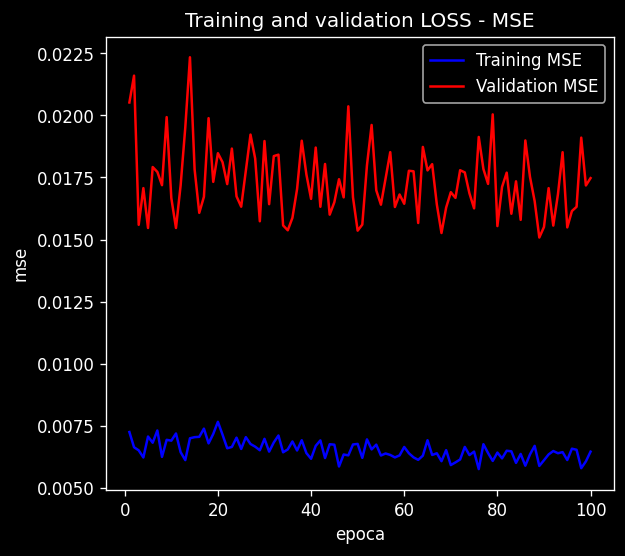

In [74]:
plot_history(history)

In [76]:
model = load_model("./modelo_lstm_ex4.hdf5")

In [77]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [78]:
trainPredict.shape

(190, 1)

In [79]:
y_train.shape

(190,)

In [80]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [82]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2292690.40 RMSE
Test Score: 3668394.48 RMSE


In [83]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [84]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

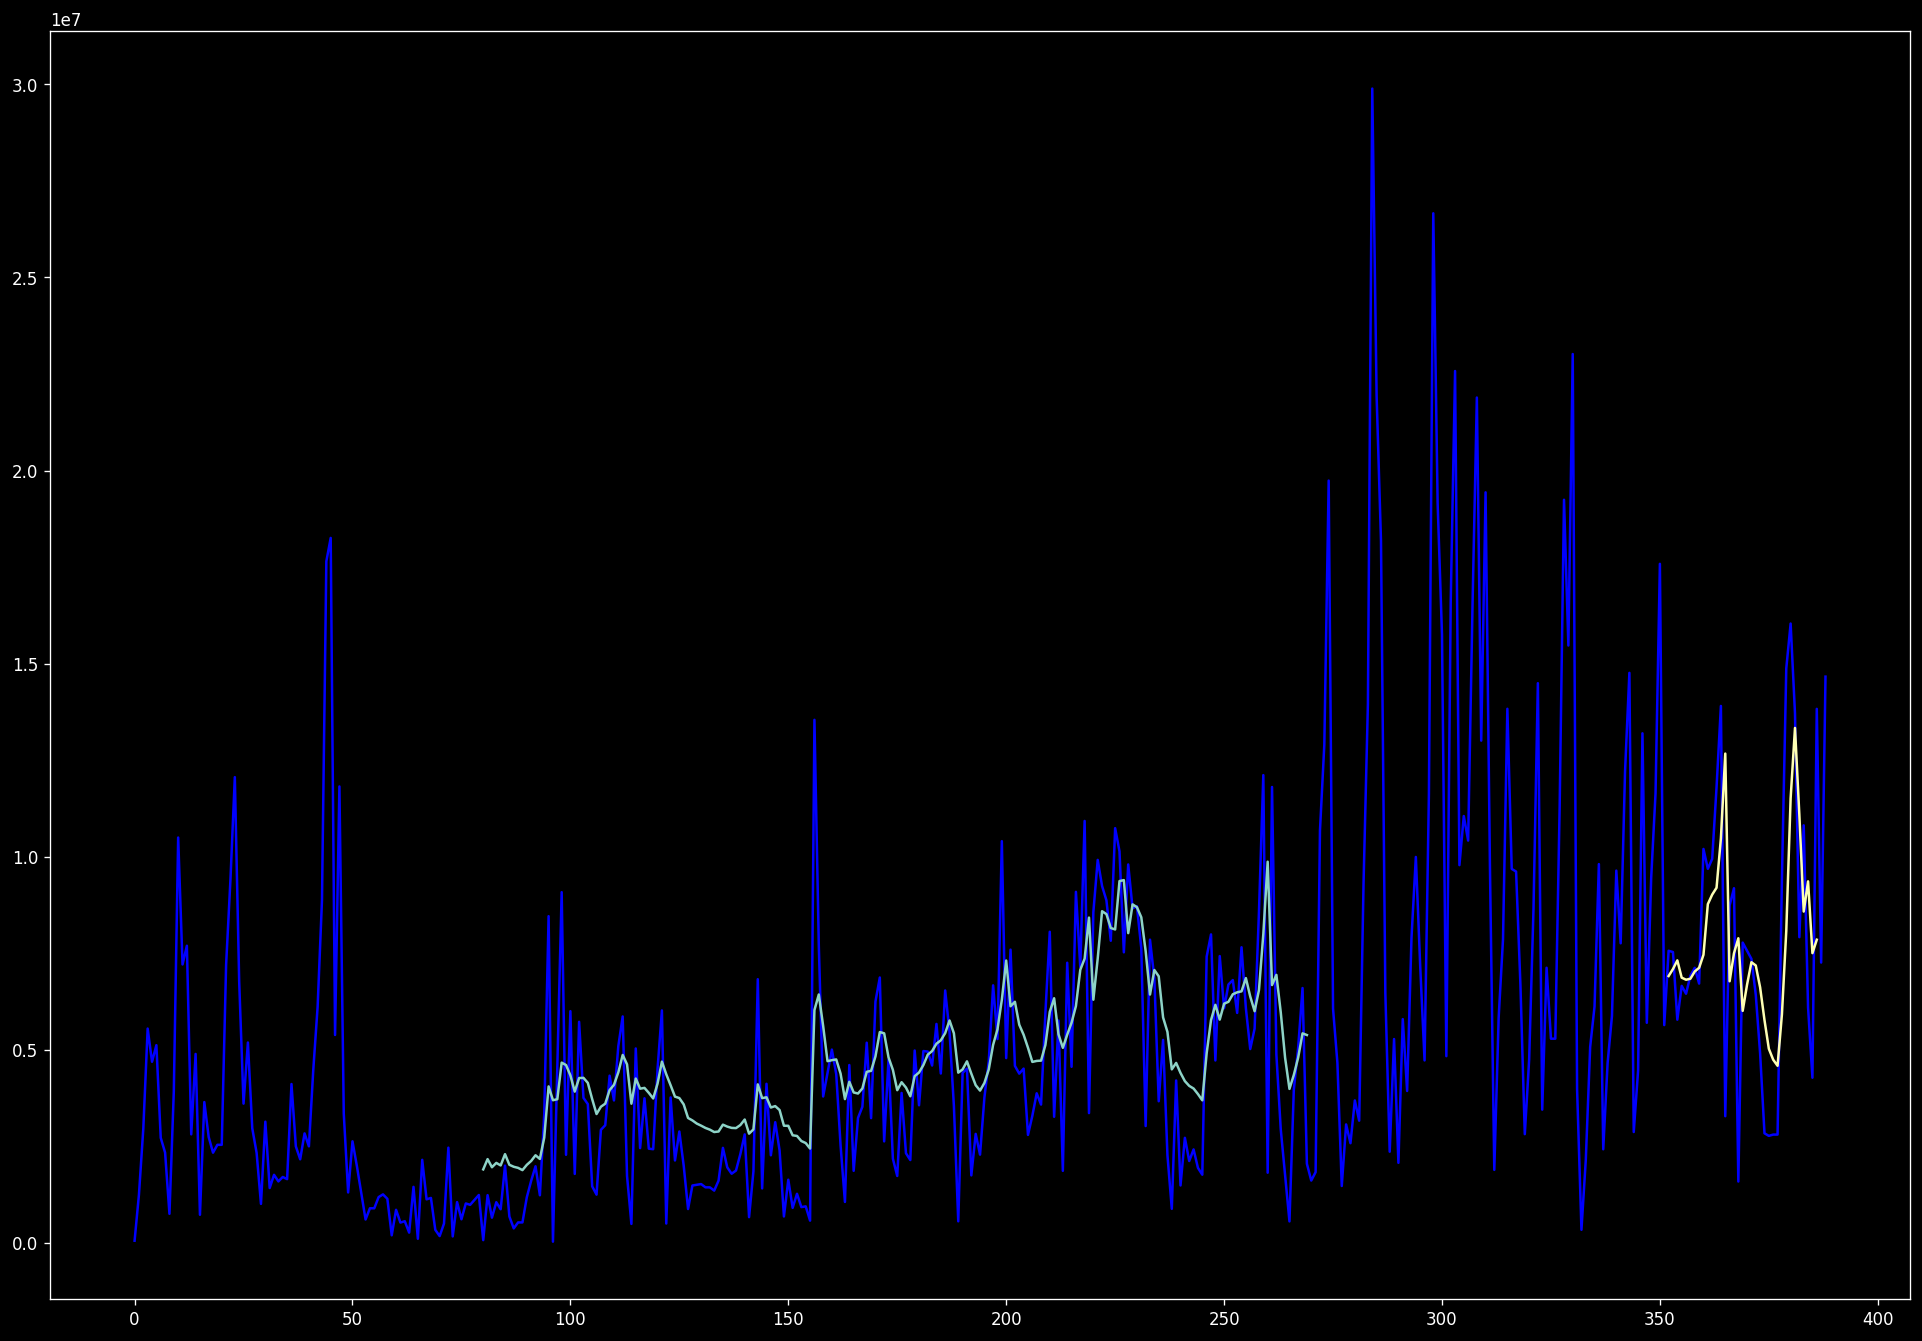

In [85]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [57]:
y_te = y_te.reshape(-1,1)

In [58]:
mean_absolute_percentage_error(testPredict, y_te)

0.3936676034141338

# Modelo GRU

In [86]:
model = Sequential()
model.add(GRU(128, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [88]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [89]:
checkpointer = ModelCheckpoint(filepath='./modelo_gru_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Epoch 1/100
189/190 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 00001: val_loss improved from inf to 0.02087, saving model to .\modelo_gru_ex4.hdf5
190/190 [==============================] - 1s 6ms/step - loss: 0.0076 - val_loss: 0.0209
Epoch 2/100
181/190 [===========================>..] - ETA: 0s - loss: 0.0074
Epoch 00002: val_loss did not improve from 0.02087
190/190 [==============================] - 1s 4ms/step - loss: 0.0071 - val_loss: 0.0283
Epoch 3/100
178/190 [===========================>..] - ETA: 0s - loss: 0.0070
Epoch 00003: val_loss improved from 0.02087 to 0.01802, saving model to .\modelo_gru_ex4.hdf5
190/190 [==============================] - 1s 4ms/step - loss: 0.0067 - val_loss: 0.0180
Epoch 4/100
184/190 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 00004: val_loss did not improve from 0.01802
190/190 [==============================] - 1s 4ms/step - loss: 0.0072 - val_loss: 0.0215
Epoch 5/100
179/190 [=========================

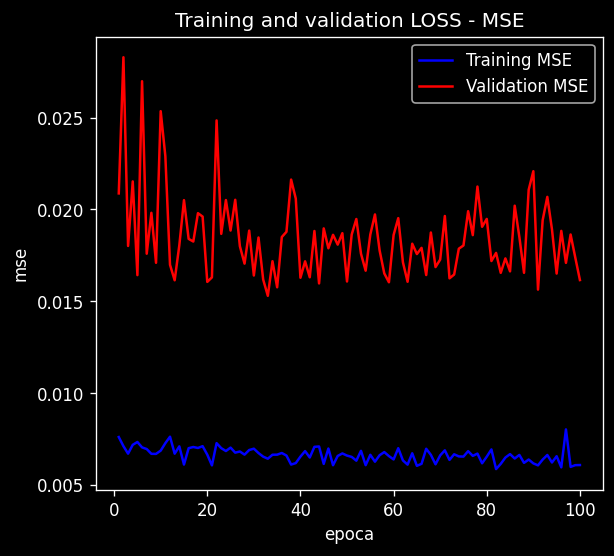

In [90]:
plot_history(history)

In [91]:
model = load_model("./modelo_gru_ex4.hdf5")

In [92]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [93]:
trainPredict.shape

(190, 1)

In [94]:
y_train.shape

(190,)

In [95]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [96]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2389498.05 RMSE
Test Score: 3694688.30 RMSE


In [97]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [98]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

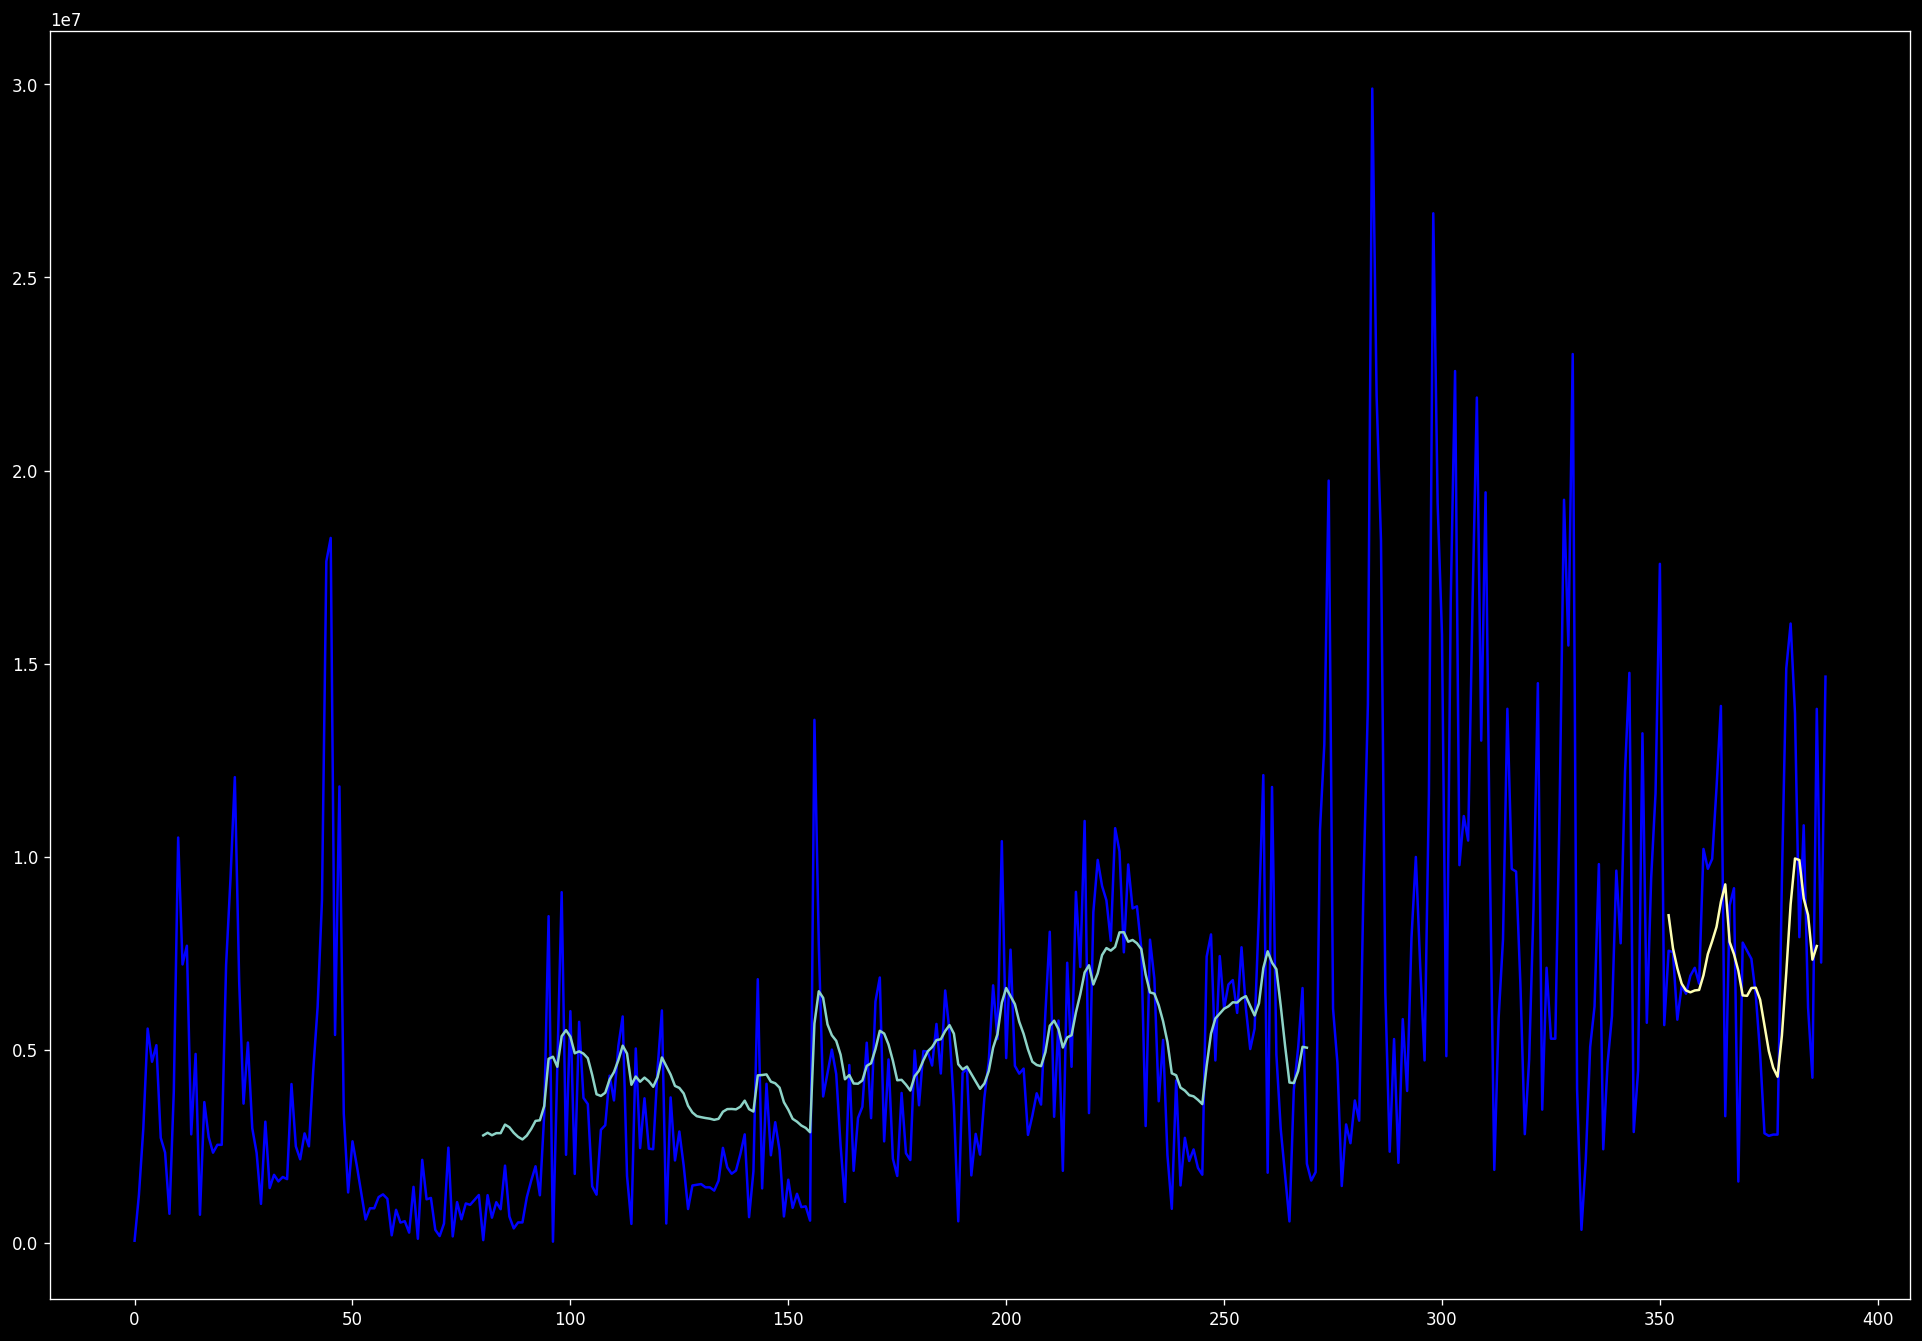

In [99]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()